In [26]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn.functional as F
from torchmetrics import Accuracy, Precision, Recall

# Definir transformaciones para normalizar los datos
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Cargar el conjunto de datos MNIST
train_dataset = datasets.FashionMNIST('data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST('data', train=False, transform=transform)

# Definir el tamaño del lote y crear los iteradores de datos
batch_size = 256
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Verificar si hay una GPU disponible y establecer el dispositivo
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('el device es',device)

# Definir la clase de convolución personalizada
import torch.nn.functional as F
'''
class MyConvolution(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size):
        super(MyConvolution, self).__init__()
        self.weight = nn.Parameter(torch.randn(out_channels, in_channels, kernel_size, kernel_size)).to(device)
        self.bias = nn.Parameter(torch.zeros(out_channels)).to(device)
        self.kernel_size = kernel_size

    def forward(self, x):
        output = F.conv2d(x, self.weight, bias=self.bias, stride=1, padding=0)
        return output
'''


class MyConvolution(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size):
        super(MyConvolution, self).__init__()
        self.weight = nn.Parameter(torch.randn(out_channels, in_channels, kernel_size, kernel_size)).to(device)
        self.bias = nn.Parameter(torch.zeros(out_channels)).to(device)
        self.kernel_size = kernel_size

    def forward(self, x):
        batch_size, in_channels, height, width = x.size()
        out_channels = self.weight.size(0)

        output_height = height - self.kernel_size + 1
        output_width = width - self.kernel_size + 1

        #en vez de tener la imagen, tenemos ahora tiras de tamaño kernel*kernel 
        # por ej. para batch de 64 y kernel de 3 y el mnist (1 input chanel, 28*28), nos queda [64, 9, 676]
        #queda 676 porque el stride es de uno, tenemos "cuadritos" traslapados y si hacemos las cuentas dan 26*26
        #y esos cuadritos se aplanan para que sean de 3*3*ïnput_channels
        x_unfolded = F.unfold(x, self.kernel_size)
        
        #y ahora separamos la dimensión de los input channels
        x_unfolded = x_unfolded.view(batch_size, in_channels, self.kernel_size *self.kernel_size , output_height * output_width) 

        #Y ahora vamos a permutar, queremos el output_height*output_width en la dim 1
        x_unfolded=x_unfolded.permute(0, 3, 1, 2)

        #y la última dimensión ahora multiplicamos las que anteriormente eran la 2 y 3
        #esto porque  en vez de la operación de convolución, vamos a hacer un producto punto entre el kernel y los pixeles correspondientes
        #debe ser de tamaño in_channels*kernel*kernel porque redcordemos que cuando convolucionamos un input de varios canales, se suma también a 
        #lo largo de los canales
        x_unfolded=x_unfolded.view(batch_size, output_height * output_width, in_channels*self.kernel_size *self.kernel_size) 

        #y ahora los pesos de nuestro kernel van a ser de [out_channels,in_channels*kernel_size*kernel_size]
        weight_view = self.weight.view(out_channels, -1)
        
        #y como dijimos, la operación de convolución (multiplicacion element-wise seguido de sumar todos esos elementos) se sustityue por dot product
        conv = torch.matmul(x_unfolded, weight_view.t())
        #conv queda con shape [64, 676, 3]
        
        #ahora necesitamos que sea de [batch,out_channels,676]
        conv =conv.permute(0, 2, 1)
        
        #cosas raras de la memoria, pero es necesario
        conv=conv.contiguous()
        
        #y separamos ahora la última dimensión
        conv = conv.view(batch_size, out_channels, output_height, output_width) #+ self.bias.unsqueeze(0)
        
        #por último le sumamos el bias. Pero como el bias era solo de tamaño out channels, tenemos que añadir dimensiones tamaño 1 para poder sumar
        #esto de añadir dimensiones de tamaño 1 en las dimensiones faltantes se conoce como broadcasting
        #es como 'duplicar' la información en esas dimensiones
        #la forma en que se suma el bias es sumar un número diferente a cada canal. 
        # Pero es el mismo número para cada pixel y el mismo para cada imagen del batch
        conv = conv + self.bias.unsqueeze(0).unsqueeze(-1).unsqueeze(-1)
        

        return conv





# Definir el modelo de la red neuronal
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        #vamos a aplicar 3 filtros
        self.conv1 = MyConvolution(1, 3, kernel_size=3)
        #ahora 2 filtros
        self.conv2 = MyConvolution(3, 6, kernel_size=3)
        #ese 5 sale de calcular de cuánto por cuanto v a a ser la imagen que sale de conv2 y después del max pool
        self.fc1 = nn.Linear(6 * 5 * 5, 128)
        #y al final hay que mapear a 2 clases
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        #print('despues de maxpool 2',x.shape)
        x = x.view(-1, 6 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Crear una instancia del modelo y moverlo a la GPU
seed = 1
torch.manual_seed(seed)

model = Net().to(device)

# Instantiate metric objects
accuracy = Accuracy(num_classes=10,average='macro',task='multiclass').to(device)
precision = Precision(num_classes=10, average='macro',task='multiclass').to(device)
recall = Recall(num_classes=10, average='macro',task='multiclass').to(device)
acc_list = []
prec_list = []
rec_list = []

# Definir la función de pérdida y el optimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Entrenamiento del modelo
epochs =10
losses = []
for epoch in range(epochs):
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(train_loader, 0):
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()

        # Calcular las salidas y la pérdida
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        

        # Realizar la retropropagación y la optimización
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 100 == 99:
            print(f'Epoch: {epoch + 1}, Batch: {i + 1}, Loss: {running_loss / 100:.3f}')
            
            #if is last batch of epoch
            #if i== train_loader.__len__()-1:
            last_running_loss_toSafe = running_loss
            running_loss = 0.0
            
    losses.append(last_running_loss_toSafe / 100)



el device es cuda
Epoch: 1, Batch: 100, Loss: 1.348
Epoch: 1, Batch: 200, Loss: 0.702
Epoch: 2, Batch: 100, Loss: 0.616
Epoch: 2, Batch: 200, Loss: 0.590
Epoch: 3, Batch: 100, Loss: 0.561
Epoch: 3, Batch: 200, Loss: 0.552
Epoch: 4, Batch: 100, Loss: 0.531
Epoch: 4, Batch: 200, Loss: 0.522
Epoch: 5, Batch: 100, Loss: 0.502
Epoch: 5, Batch: 200, Loss: 0.505
Epoch: 6, Batch: 100, Loss: 0.491
Epoch: 6, Batch: 200, Loss: 0.493
Epoch: 7, Batch: 100, Loss: 0.477
Epoch: 7, Batch: 200, Loss: 0.480
Epoch: 8, Batch: 100, Loss: 0.463
Epoch: 8, Batch: 200, Loss: 0.475
Epoch: 9, Batch: 100, Loss: 0.459
Epoch: 9, Batch: 200, Loss: 0.459
Epoch: 10, Batch: 100, Loss: 0.460
Epoch: 10, Batch: 200, Loss: 0.450


In [27]:
# Evaluación del modelo
correct = 0
total = 0
prec_list=[]
rec_list=[]
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        prec_list.append(precision(predicted, labels).item())
        rec_list.append(recall(predicted, labels).item())
        

accuracy = correct / total
prec=sum(prec_list)/len(test_loader)
rec=sum(rec_list)/len(test_loader)
print(f'Accuracy on the test set: {accuracy * 100:.2f}%')
print('Precision y Recall:',prec,rec)


Accuracy on the test set: 80.34%
Precision y Recall: 0.8126411214470863 0.8024899393320084


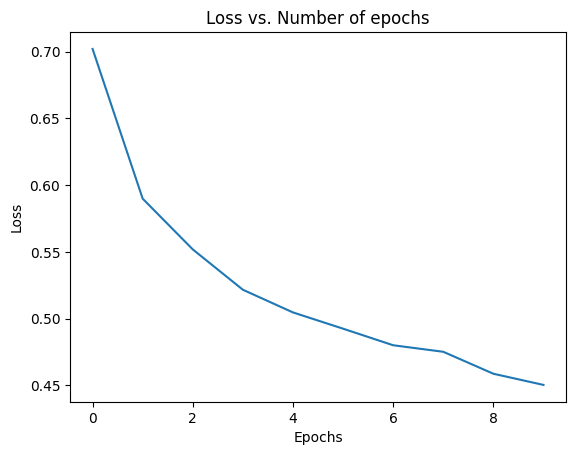

In [29]:
#grafico de la perdida
import matplotlib.pyplot as plt
plt.plot(losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs. Number of epochs')
plt.show()
